# Classification stéréotypies

## Import

In [1]:
from os import listdir
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T
from torchvision.io import read_image
import torchvision.models as models
import torchvision

import skimage.transform

from torch.utils.tensorboard import SummaryWriter

import time
import copy

/media/HDD/planaire_classification/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prétraitement & datasets

In [6]:
data_dir = "../data/datasets/Labels_pooling_LR_dataset_augmented"

### Prétraitement

In [4]:
def images_count(folder, title=None):
    labels = listdir(folder)
    count = []

    for label in labels:
        imgs = listdir(f"{folder}/{label}")
        count.append(len(imgs))
    
    fig, ax = plt.subplots()
    y_pos = np.arange(len(labels))

    ax.barh(y_pos, count)
    for bars in ax.containers:
        ax.bar_label(bars)
    ax.set_yticks(y_pos, labels=labels)
    ax.invert_yaxis()
    ax.set_xlabel('Nombre d\'images')
    if title == None:
        ax.set_title('Nombre d\'images par label')
    else:
        ax.set_title(title)

    plt.show()

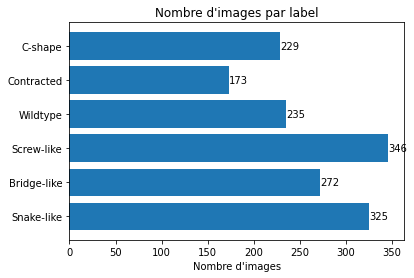

In [5]:
images_count(data_dir)

In [44]:
import shutil

def split_train_val_dataset(dataset):
    labels = listdir(dataset)

    Path(f"{dataset}/train").mkdir(parents=True, exist_ok=True)
    Path(f"{dataset}/val").mkdir(parents=True, exist_ok=True)
    
    print(labels)

    for l in labels:
        print(l)
        train_path = f"{dataset}/train/{l}"
        val_path = f"{dataset}/val/{l}"
        
        Path(train_path).mkdir(parents=True, exist_ok=True)
        Path(val_path).mkdir(parents=True, exist_ok=True)

        for count, img in enumerate(listdir(f"{dataset}/{l}")):
            if count%10 == 0:
                shutil.copyfile(f"{dataset}/{l}/{img}", f"{val_path}/{img}")
            else:
                shutil.copyfile(f"{dataset}/{l}/{img}", f"{train_path}/{img}")

In [45]:
split_train_val_dataset(data_dir)

['C-shape', 'Contracted', 'Wildtype', 'Screw-like', 'Bridge-like', 'Snake-like']
C-shape
Contracted
Wildtype
Screw-like
Bridge-like
Snake-like


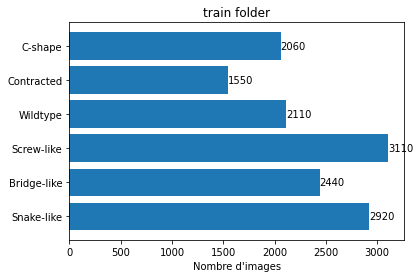

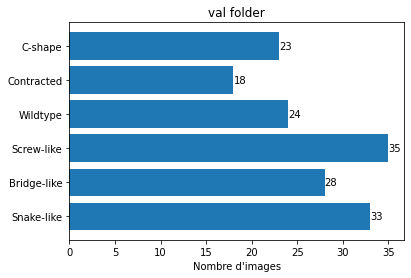

In [7]:
images_count(f"{data_dir}/train", title='train folder')
images_count(f"{data_dir}/val", title='val folder')

### Datasets

In [8]:
# Data augmentation and normalization for training
mean = [0.6248, 0.5959, 0.5339]
std  = [0.1259, 0.1148, 0.1080]

data_transforms = {
    'train': T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean, std)
    ]),
    'val': T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean, std)
    ]),
}

image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=1)
                for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

trainloader = dataloaders['train']

torch.Size([32, 3, 224, 224])


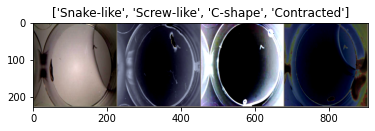

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
print(inputs.size())

out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes][:4])


## Modèles

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25, log_name='logs'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    summary_writer = SummaryWriter(log_dir=f"logs/augmented/{log_name}")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                summary_writer.add_scalar(
				'losses/train_loss', epoch_loss, global_step=epoch)
                summary_writer.add_scalar(
				'acc/train_acc', epoch_acc * 100, global_step=epoch)
            else :
                summary_writer.add_scalar(
                    'losses/val_loss', epoch_loss, global_step=epoch)
                summary_writer.add_scalar(
                    'acc/val_acc', epoch_acc * 100, global_step=epoch)
            # deep copy the model
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Utils

In [14]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  layer = model.features[layer_num].cpu()
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[layer_num].weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

In [12]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

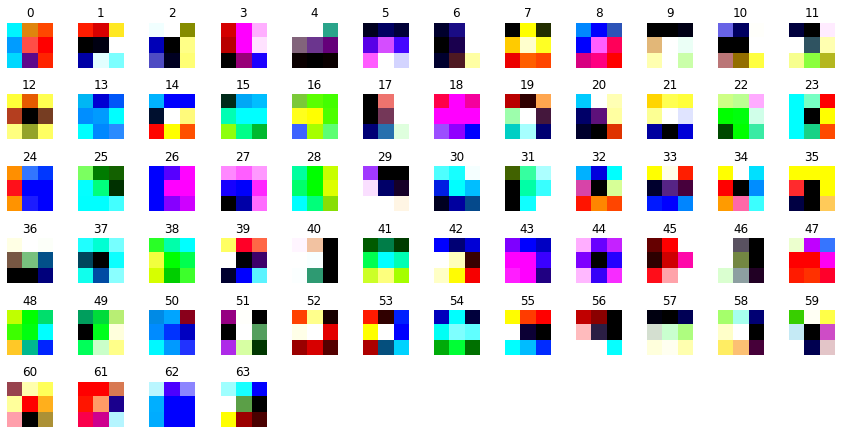

In [18]:
plot_weights(vgg16_model, 0, single_channel = False)

In [15]:
    def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))

### VGG-16

In [16]:
vgg16_model = torchvision.models.vgg16(pretrained=True)
for param in vgg16_model.parameters():
    param.requires_grad = False
vgg16_model.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [17]:
num_ftrs = vgg16_model.classifier[6].in_features

vgg16_model.classifier[6] = nn.Linear(num_ftrs, 6)
vgg16_model = vgg16_model.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer_ft = optim.SGD(vgg16_model.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft = optim.Adam(vgg16_model.parameters(), lr=0.001, weight_decay=0.0)

#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

vgg16_model.classifier[6]

Linear(in_features=4096, out_features=6, bias=True)

In [18]:
out = train_model(vgg16_model, criterion, optimizer_ft, num_epochs=25, log_name="vgg16_25")

Epoch 0/24
----------
train Loss: 1.1994 Acc: 0.5441
val Loss: 0.8276 Acc: 0.7329

Epoch 1/24
----------
train Loss: 1.0559 Acc: 0.6107
val Loss: 0.7976 Acc: 0.7205

Epoch 2/24
----------
train Loss: 1.0297 Acc: 0.6295
val Loss: 0.7703 Acc: 0.7578

Epoch 3/24
----------
train Loss: 1.0262 Acc: 0.6311
val Loss: 0.8127 Acc: 0.7329

Epoch 4/24
----------
train Loss: 1.0100 Acc: 0.6419
val Loss: 0.7190 Acc: 0.7578

Epoch 5/24
----------
train Loss: 1.0003 Acc: 0.6462
val Loss: 0.7055 Acc: 0.7640

Epoch 6/24
----------
train Loss: 1.0038 Acc: 0.6449
val Loss: 0.7110 Acc: 0.7702

Epoch 7/24
----------
train Loss: 1.0187 Acc: 0.6431
val Loss: 0.7017 Acc: 0.7764

Epoch 8/24
----------
train Loss: 1.0086 Acc: 0.6479
val Loss: 0.6979 Acc: 0.7640

Epoch 9/24
----------
train Loss: 1.0144 Acc: 0.6438
val Loss: 0.7415 Acc: 0.7391

Epoch 10/24
----------
train Loss: 1.0185 Acc: 0.6474
val Loss: 0.6940 Acc: 0.7950

Epoch 11/24
----------
train Loss: 0.9941 Acc: 0.6532
val Loss: 0.7180 Acc: 0.7764

Ep

KeyboardInterrupt: 

In [24]:
best_model_state = vgg16_model.state_dict()
torch.save(best_model_state, f"../models/vgg16.pt")

In [14]:
torch.cuda.empty_cache()

### VGG-19

In [24]:
vgg19_model = torchvision.models.vgg19(pretrained=True)
for param in vgg19_model.parameters():
    param.requires_grad = False
vgg19_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [25]:
num_ftrs = vgg19_model.classifier[6].in_features

vgg19_model.classifier[6] = nn.Linear(num_ftrs, 6)
vgg19_model = vgg19_model.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer_ft = optim.SGD(vgg16_model.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft = optim.Adam(vgg19_model.parameters(), lr=0.001, weight_decay=0.0)

#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

vgg19_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=6, bias=True)
)

In [26]:
out = train_model(vgg19_model, criterion, optimizer_ft, num_epochs=35, log_name='vgg19_bs35_hflip_vflip')

Epoch 0/34
----------
train Loss: 1.4532 Acc: 0.4278
val Loss: 1.2197 Acc: 0.6025

Epoch 1/34
----------
train Loss: 1.1233 Acc: 0.5835
val Loss: 1.1426 Acc: 0.5901

Epoch 2/34
----------
train Loss: 0.9956 Acc: 0.6089
val Loss: 1.0865 Acc: 0.5776

Epoch 3/34
----------
train Loss: 1.0036 Acc: 0.6180
val Loss: 1.0075 Acc: 0.6460

Epoch 4/34
----------
train Loss: 0.9460 Acc: 0.6392
val Loss: 1.0326 Acc: 0.6273

Epoch 5/34
----------
train Loss: 0.9334 Acc: 0.6561
val Loss: 0.9777 Acc: 0.6708

Epoch 6/34
----------
train Loss: 0.9148 Acc: 0.6469
val Loss: 0.9647 Acc: 0.6398

Epoch 7/34
----------
train Loss: 0.8859 Acc: 0.6779
val Loss: 0.9369 Acc: 0.6522

Epoch 8/34
----------
train Loss: 0.8786 Acc: 0.6688
val Loss: 0.9607 Acc: 0.6398

Epoch 9/34
----------
train Loss: 0.9162 Acc: 0.6589
val Loss: 0.9563 Acc: 0.6460

Epoch 10/34
----------
train Loss: 0.8738 Acc: 0.6702
val Loss: 0.9037 Acc: 0.6894

Epoch 11/34
----------
train Loss: 0.8027 Acc: 0.7012
val Loss: 0.8631 Acc: 0.6957

Ep

### ConvNext

In [6]:
convnext_model = torchvision.models.convnext_base(pretrained=True)

In [7]:
convnext_model.classifier

Sequential(
  (0): LayerNorm2d((1024,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1024, out_features=1000, bias=True)
)

In [8]:
for param in convnext_model.parameters():
    param.requires_grad = False

In [9]:
num_ftrs = convnext_model.classifier[2].in_features

convnext_model.classifier[2] = nn.Linear(num_ftrs, 6)
convnext_model = convnext_model.to(device)

criterion = nn.CrossEntropyLoss()
#optimizer_ft = optim.SGD(vgg16_model.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft = optim.Adam(convnext_model.parameters(), lr=0.001, weight_decay=0.0)

#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

convnext_model.classifier

Sequential(
  (0): LayerNorm2d((1024,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1024, out_features=6, bias=True)
)

In [10]:
out = train_model(convnext_model, criterion, optimizer_ft, num_epochs=25, log_name='convnext_temp')

Epoch 0/24
----------
train Loss: 1.4930 Acc: 0.4101
val Loss: 1.2453 Acc: 0.6398

Epoch 1/24
----------
train Loss: 1.1703 Acc: 0.6145
val Loss: 1.1178 Acc: 0.6646

Epoch 2/24
----------
train Loss: 1.0258 Acc: 0.6681
val Loss: 1.0452 Acc: 0.6522

Epoch 3/24
----------
train Loss: 0.9555 Acc: 0.6864
val Loss: 0.9368 Acc: 0.6894

Epoch 4/24
----------
train Loss: 0.8797 Acc: 0.7132
val Loss: 0.9121 Acc: 0.7205

Epoch 5/24
----------
train Loss: 0.8250 Acc: 0.7463
val Loss: 0.9077 Acc: 0.7516

Epoch 6/24
----------
train Loss: 0.7872 Acc: 0.7484
val Loss: 0.8642 Acc: 0.7267

Epoch 7/24
----------
train Loss: 0.7701 Acc: 0.7470
val Loss: 0.8403 Acc: 0.7516

Epoch 8/24
----------
train Loss: 0.7427 Acc: 0.7583
val Loss: 0.8030 Acc: 0.7888

Epoch 9/24
----------
train Loss: 0.7110 Acc: 0.7632
val Loss: 0.8047 Acc: 0.7826

Epoch 10/24
----------
train Loss: 0.6912 Acc: 0.7766
val Loss: 0.8100 Acc: 0.7702

Epoch 11/24
----------
train Loss: 0.6862 Acc: 0.7808
val Loss: 0.7840 Acc: 0.7826

Ep

### Custom model

torch.Size([32, 3, 224, 224])

In [11]:
class Custom(nn.Module):
    def __init__(self, nb_classes):
        super(Custom, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=8,
                               kernel_size=3)
        self.bn1 = nn.BatchNorm2d(8) # nb de channels out

        self.conv2 = nn.Conv2d(in_channels=8,
                               out_channels=16,
                               kernel_size=3)
        self.bn2 = nn.BatchNorm2d(16) # nb de channels out
        
        self.conv3 = nn.Conv2d(in_channels=16,
                               out_channels=32,
                               kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32) # nb de channels out
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout()

        # self.fc1 = nn.Linear(21632, 1000)
        # self.fc2 = nn.Linear(1000,50)
        # self.fc_out = nn.Linear(50, nb_classes)

        self.fc1 = nn.Linear(21632, 5000)
        self.fc2 = nn.Linear(5000,100)
        self.fc_out = nn.Linear(100, nb_classes)

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))

        x = x.view(-1, 21632) # flatten
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(self.dropout(x)))
        x= self.fc_out(x)

        return x

In [12]:
custom_model = Custom(nb_classes=6)
custom_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(custom_model.parameters(), lr=0.001, weight_decay=0.0)

custom_model

Custom(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=21632, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=100, bias=True)
  (fc_out): Linear(in_features=100, out_features=6, bias=True)
)

In [13]:
out = train_model(custom_model, criterion, optimizer_ft, num_epochs=25, log_name='custom_base')

Epoch 0/24
----------
train Loss: 1.7671 Acc: 0.5525
val Loss: 1.0420 Acc: 0.5963

Epoch 1/24
----------
train Loss: 0.8462 Acc: 0.6949
val Loss: 1.0643 Acc: 0.6398

Epoch 2/24
----------
train Loss: 0.7758 Acc: 0.7209
val Loss: 0.9836 Acc: 0.5963

Epoch 3/24
----------
train Loss: 0.6920 Acc: 0.7400
val Loss: 0.9420 Acc: 0.6584

Epoch 4/24
----------
train Loss: 0.6569 Acc: 0.7393
val Loss: 0.9505 Acc: 0.6398

Epoch 5/24
----------
train Loss: 0.6092 Acc: 0.7696
val Loss: 0.9717 Acc: 0.6708

Epoch 6/24
----------
train Loss: 0.6236 Acc: 0.7597
val Loss: 0.9503 Acc: 0.6708

Epoch 7/24
----------
train Loss: 0.5523 Acc: 0.7844
val Loss: 1.0666 Acc: 0.6832

Epoch 8/24
----------
train Loss: 0.5489 Acc: 0.7851
val Loss: 0.9434 Acc: 0.7081

Epoch 9/24
----------
train Loss: 0.5171 Acc: 0.7956
val Loss: 1.0596 Acc: 0.6398

Epoch 10/24
----------
train Loss: 0.5186 Acc: 0.8097
val Loss: 0.9826 Acc: 0.6770

Epoch 11/24
----------
train Loss: 0.4832 Acc: 0.8210
val Loss: 1.2980 Acc: 0.6957

Ep

## Analyse

In [16]:
model = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/thomas/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 30.8MB/s]


### Features mask

In [3]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.6248, 0.5959, 0.5339], std=[0.1259, 0.1148, 0.1080])
])

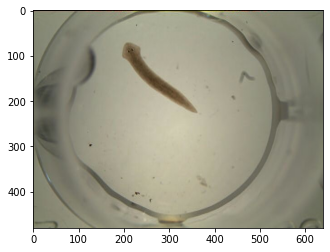

In [17]:
from PIL import Image
image = Image.open('/media/HDD/planaire_classification/data/Labels_pooling_LR_dataset/val/Wildtype/12-04-22_L-glutamate_1_T15_07_frame14.jpg')
plt.imshow(image)

In [19]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []# get all the model children as list
#model_children = model.features
model_children = list(model.children())
counter = 0#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
for layer in conv_layers:
    print(layer)

Total convolution layers: 17
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel

In [20]:
model = model.to(device)

In [21]:
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [22]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

17
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])


In [23]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
    for fm in processed:
        print(fm.shape)

(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(56, 56)
(56, 56

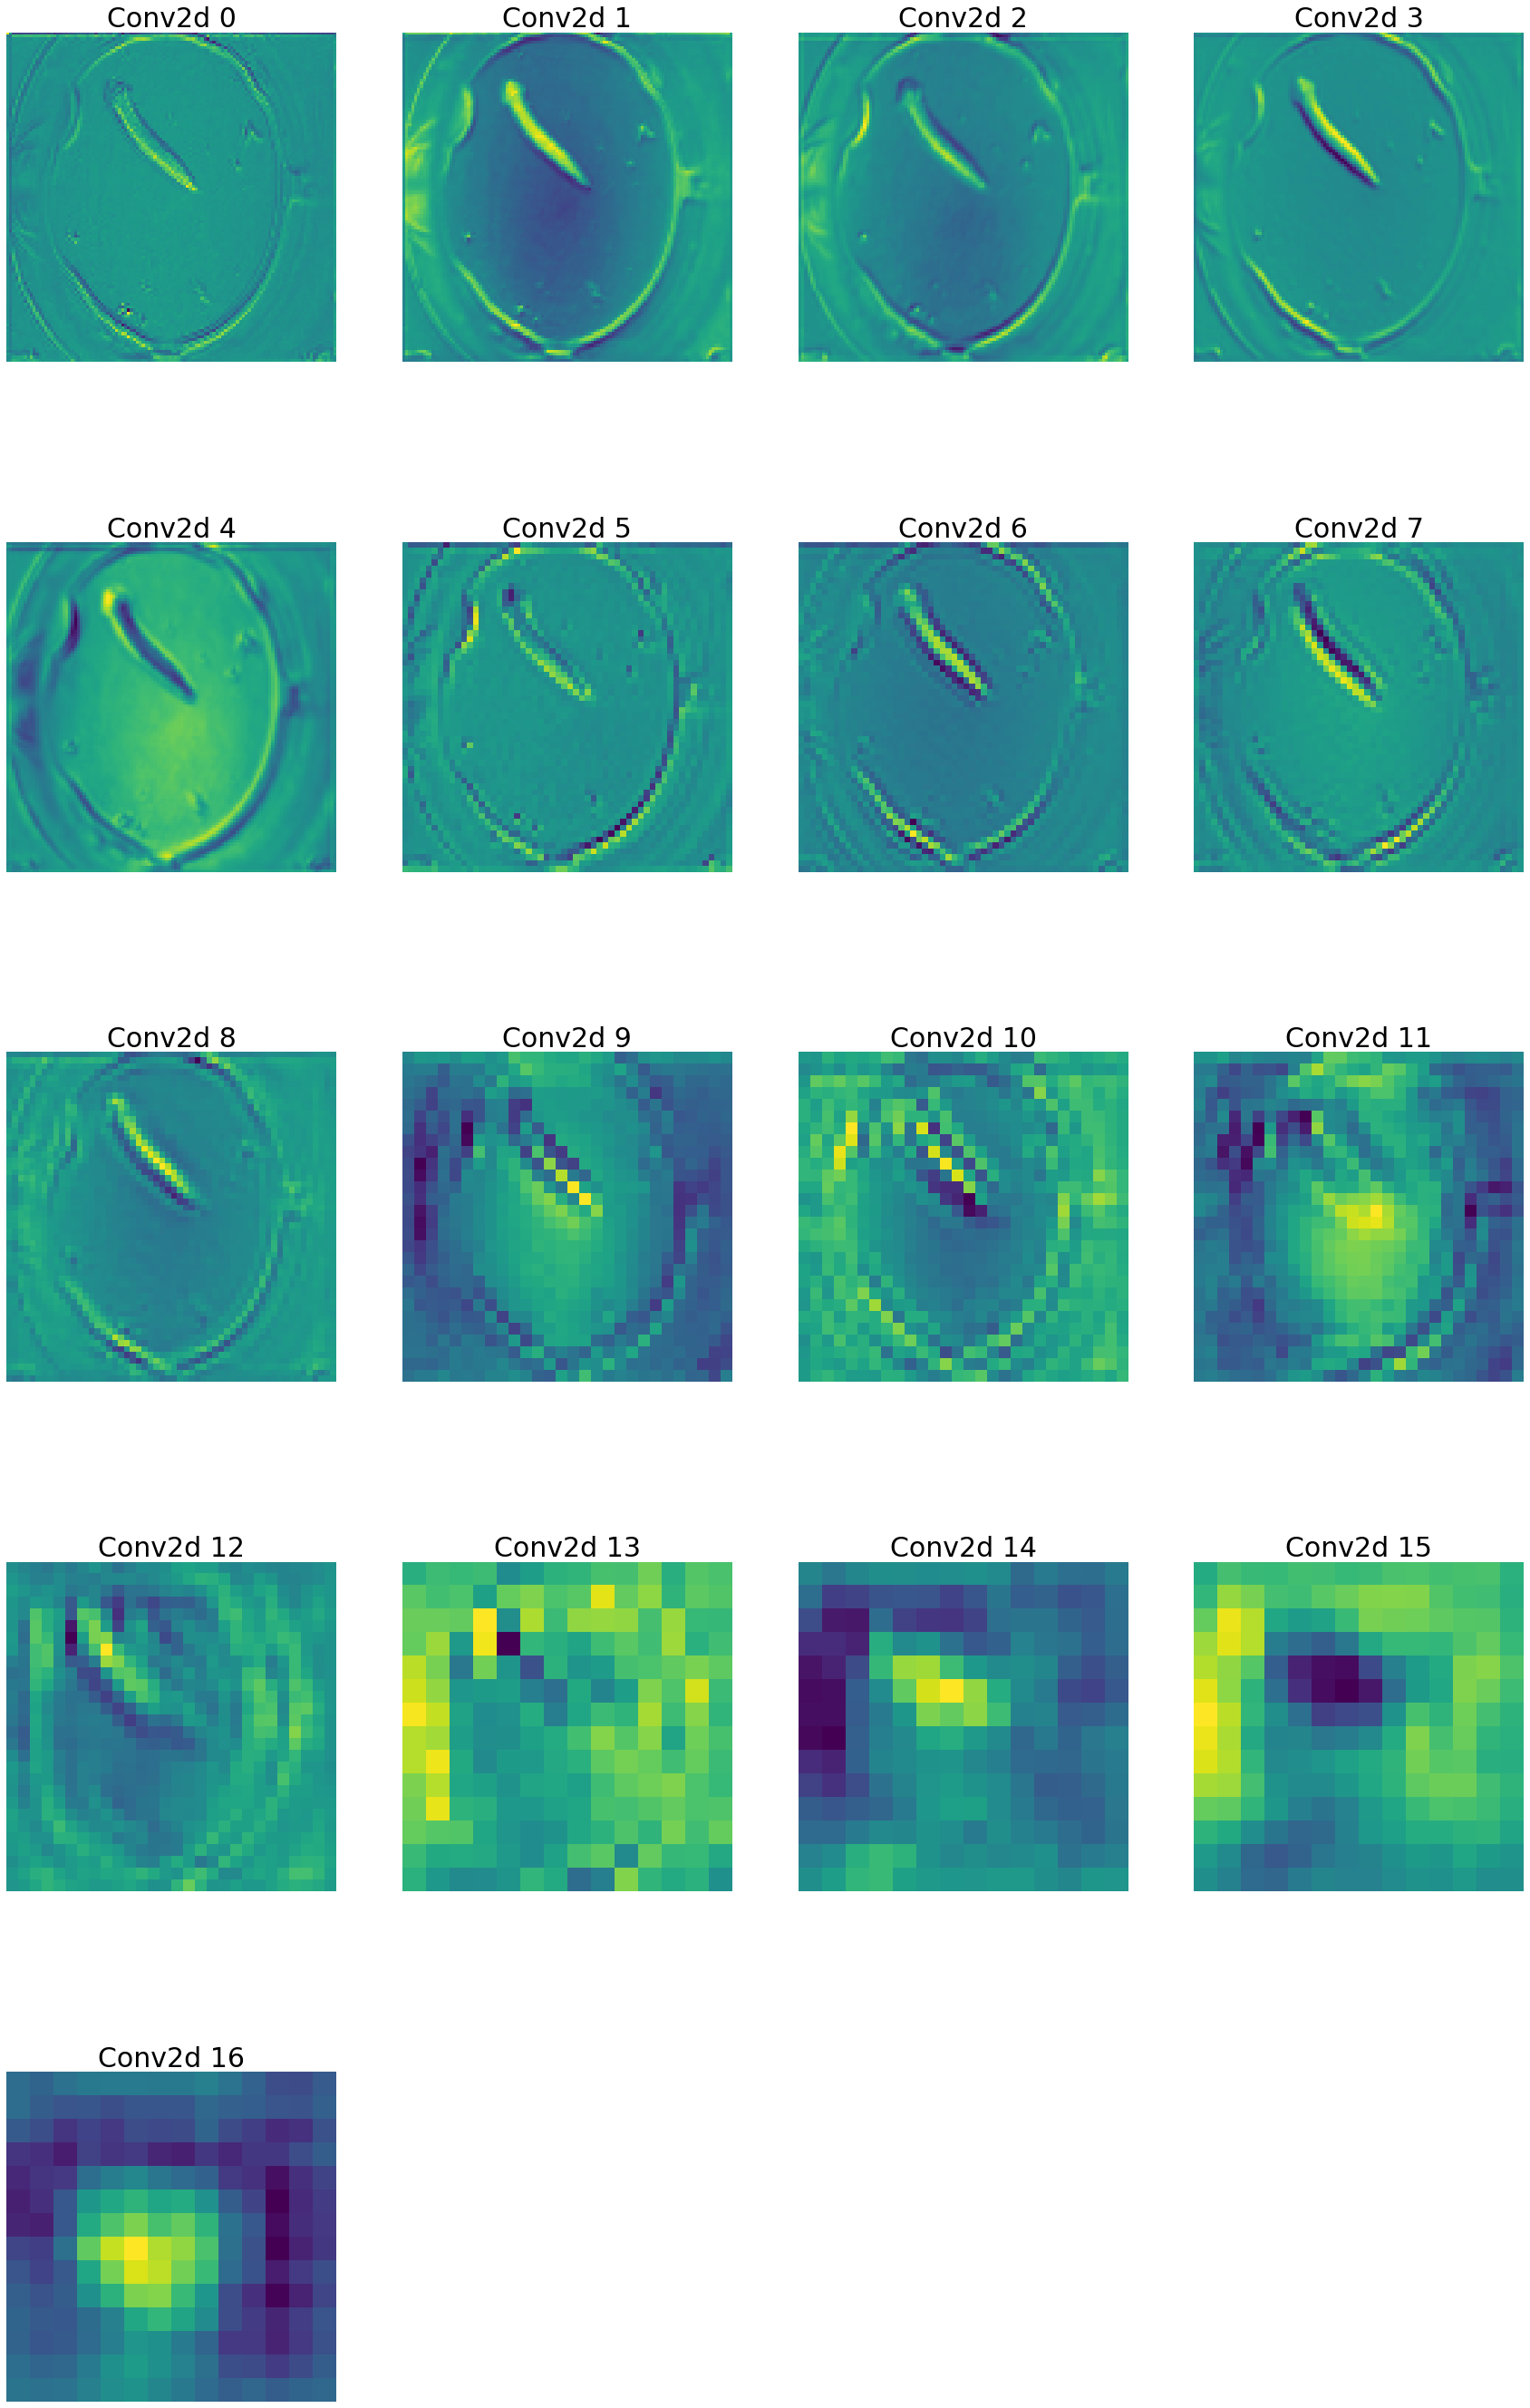

In [24]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0] + ' ' + str(i), fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

### Confusion matrix

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 0 1 3]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 3 1 1 1 1 1 3 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 3 1 1 1 1 1 1 1 2 2 1 3 1 1 1 1 1 0 1 1 1 3 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 3 1 1 1 1 1]
[1]
['Bridge-like', 'C-shape', 'Contracted', 'Screw-like', 'Snake-like', 'Wildtype']


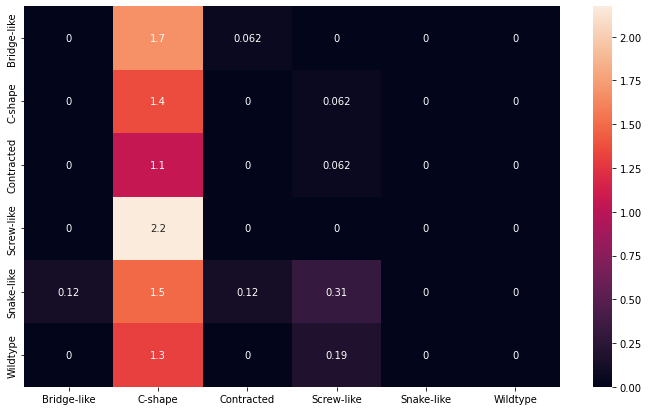

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders['val']:
        convnext_model.eval
        output = convnext_model(inputs.to(device)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        print(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = image_datasets['val'].classes
print(classes)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('cf_matrix.png')

['Bridge-like', 'C-shape', 'Contracted', 'Screw-like', 'Snake-like', 'Wildtype']


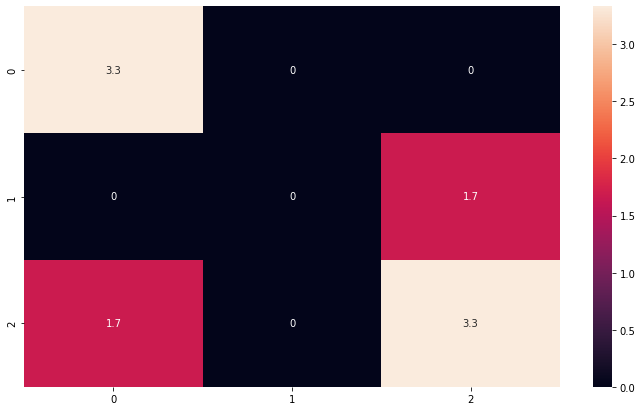

In [32]:
y_pred = [0, 0, 2, 2, 0, 2]
y_true = [2, 0, 2, 2, 0, 1]


classes = image_datasets['val'].classes
print(classes)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10)
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')